<a href="https://colab.research.google.com/github/yanxiaoqi932/Machine-Learning/blob/main/MyHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine learning homework 1:
##  regression

# 训练集文件和测试集文件下载

In [1]:
#下载文件
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 63.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 42.8MB/s]


In [2]:
#定义文件路径
tr_path = '/content/covid.train.csv'
tt_path = '/content/covid.test.csv'

# 导入有关的包，并定义随机数种子

In [3]:
'''导入有关的包'''
#Pytorch系列
import torch
import torch.nn as nn   #神经网络包
from torch.utils.data import Dataset,DataLoader   #数据集和数据加载库
from torch.optim.lr_scheduler import StepLR     #修改学习率所用

#传统数据处理库
import numpy as np
import csv
import os   #路径操作和进程管理等

#画图库
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#设置随机种子（seed）
'''如有不懂，可以查询Pytorch文档网址:
  https://pytorch.org/docs/stable/backends.html
'''
torch.backends.cudnn.deterministic = True   #顾名思义，将这个 flag 置为True的话，每次返回的卷积算法将是确定的，即默认算法。
                        #如果配合上设置 Torch 的随机种子为固定值的话，应该可以保证每次运行网络的时候相同输入的输出是固定的
torch.backends.cudnn.benchmark = False   #如果为 True，则导致 cuDNN 对多个卷积算法进行基准测试并选择最快的。 
myseed = 42069         #随机数种子选择对结果是有一定影响的，可见https://blog.csdn.net/weixin_43991828/article/details/114378660
torch.manual_seed(myseed)   #如果是cpu，则在此设置种子
torch.cuda.manual_seed(myseed)     #如果是gpu，则在此设置种子
if torch.cuda.is_available:      #如果有多个gpu，则全部设置该种子
  torch.cuda.manual_seed_all(myseed)


# 数据集的建立和处理

In [12]:
class COVID19Dataset(Dataset):
  '''数据集下载和处理'''
  def __init__(self,path,mode='train',target_only=False): #target_only用于对feature进行选择，默认全部feature都选择,如果是True则选择自定义的部分
    self.mode = mode      #训练/验证/测试
    with open(path,'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:,1:].astype(float) #去除行头和列头，得到矩阵

    #关于features的选取
    if not target_only:   #target_only为false
      features = list(range(93)) #40 states + day 1(18) + day2(18) + day3(17)，共93个特征
    else:
      # features = list(range(40)) + [57,75]
      features = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]
    
    alldata = torch.FloatTensor(data[:,features])    #特征数据
    alltarget = torch.FloatTensor(data[:,-1])    #训练目标

    #对于测试集的数据处理
    if mode == 'test':
      self.data = torch.FloatTensor(alldata)  #取出所有特征数据，测试集没有目标结果数据
    
    #对于训练集的数据处理
    elif mode == 'train':
      indices = [i for i in range(len(alldata)) if i%10!=0]   #每10个数据中取出9个作为训练集
      self.data = torch.FloatTensor(alldata[indices])
      self.target = torch.FloatTensor(alltarget[indices])
      #存储归一化后的训练集数据为csv文件，方便检查问题
      with open('Ztrain_data.csv','w') as fp:
        writer = csv.writer(fp)
        z_score_tensor = self.data;
        z_score_numpy = z_score_tensor.numpy()
        for i in range(z_score_numpy.shape[0]):
          writer.writerow(z_score_numpy[i,:])

    #对于验证集的数据处理
    else:
      print('dev')
      indices = [i for i in range(len(alldata)) if i%10==0]   #每10个数据中取出1个作为验证集
      self.data = torch.FloatTensor(alldata[indices])
      self.target = torch.FloatTensor(alltarget[indices])
    
    #打印完成语句
    self.dim = self.data.shape[1]
    print('Finished reading the {} set of COVID dataset ({} samples found,each dim = {})'.format(mode,len(self.data),self.dim))
    
    #对测试集、训练集、验证集的数据进行标准化处理
    #Z-score标准化数据（day123的features数据）
    # self.data[:,40:] = (self.data[:,40:] - self.data[:,40:].mean(dim=0,keepdim=True)) / (self.data[:,40:].std(dim=0,keepdim=True))
    self.data[:,:] = (self.data[:,:] - self.data[:,:].mean(dim=0,keepdim=True)) / (self.data[:,:].std(dim=0,keepdim=True))
  #返回一个batch
  def __getitem__(self,index):
    if self.mode in ['train','dev']:
      return self.data[index],self.target[index]
    else:
      return self.data[index]
  
  #返回数据的长度
  def __len__(self):
    return len(self.data)


In [13]:
'''Dataloader数据加载器，Dataset创建数据集，DataLoader做进一步处理，最终建立并返回一个成型的数据集'''
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
  dataset = COVID19Dataset(path,mode=mode,target_only=target_only)  #构造一个数据集
  dataloader = DataLoader(dataset,batch_size,shuffle=(mode=='train'),drop_last=False,  
                          num_workers=n_jobs,pin_memory=True)
  #batch_size代表每批要加载的数据数；
  #shuffle为true则在每一个epoch会对数据洗牌；
  #drop_out为True时，如果数据集大小不能被批处理大小整除，则设置为删除最后一个不完整的批处理，否则保留size较小的最后一批；
  #num_workers代表数据加载时的子进程数；
  #pin_memory为True时，数据加载器将在返回之前将张量复制到 CUDA 固定内存中
  return dataloader

# 建立DNN深度神经网络

In [35]:
'''创建一个神经网络，并且定义其中的输入输出维度、损失函数等'''
class NeuralNet(nn.Module):
  def __init__(self,input_dim):
    super(NeuralNet,self).__init__();

    #定义网络结构和激活函数
    self.net = nn.Sequential(
      # nn.Linear(input_dim,64),
      # nn.ReLU(),
      # nn.Linear(64,1),

      nn.Linear(input_dim, 64),
      nn.BatchNorm1d(64),
      nn.Dropout(p=0.2),
      nn.LeakyReLU(),
      nn.Linear(64,1)
    )

    #定义损失函数
    self.criterion = nn.MSELoss(reduction='mean')  #损失函数为L2范式，即均方差形式
  
  def forward(self,batch_size):
    return self.net(batch_size).squeeze(1)  #定义模型的batch_size,并且将它降一个维度

  def cal_loss(self,pred,target):   #计算模型预测值与验证集真实结果的方差
    regularization_loss = 0
    for param in model.parameters():
      regularization_loss += torch.sum(param ** 2)
      # TODO: you may implement L1/L2 regularization here
    return self.criterion(pred, target) + 0.00095 * regularization_loss  #加入正则项
    '''
    个人认为这里的加入正则项，是模型的参数越大，那么overfitting越严重，就应当引入正则项来抑制模型参数过大；
    举例如下：
      Y = w0 *X0 + w1*X1 + w2*X2 + w3*X3 + … + wd*Xd
      如果w2非常大比如106，那么如果X2加一个噪声变为X2 + △, 那么w2*(X2 + △) = W2 * X2 + W2△ 
      由于W2越大，那么W2△就很大，相当于放大了噪声的影响，模型的鲁棒性就下降，因此会导致模型泛化能力变弱，
      因此加入正则惩罚（减小）了w的值，减少模型过拟合，提高了模型的泛化能力。
    '''

# 训练过程定义

In [36]:
'''对训练集进行训练，并记录loss，生成模型'''
def train(tr_set,dv_set,model,config,device):   #训练集的运行（注意，训练集跑一次，验证集也要跑一次）
  
  #优化器设置
  optimizer = getattr(torch.optim,config['optimizer'])(model.parameters(),**config['optim_hparas']) #getattr()函数用于返回一个对象属性值
  #也可以直接在这里设置：optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  min_mse = 1000  #初始化损失为1000
  loss_record = {'train':[],'dev':[]}   #loss在训练集和验证集上的大小

  early_stop_cnt = 0    #保持最小loss没有被刷新的最长epoches量
  epoch = 0   #epoch量
  n_epoches = config['n_epoches']   #最大训练epoch量，由字典config存储

  #开始训练
  while epoch<n_epoches:
    #首先在模型集上训练模型，并得到训练集的loss
    model.train()   #将模型设置为训练模式
    tr_loss = 0   #记录训练集的测试精度
    for x,y in tr_set:  #x为训练集特征数据，y为训练集目标数据（见于COVID19Dataset）
      '''接下来是基本的迭代步骤'''
      optimizer.zero_grad()
      x,y = x.to(device),y.to(device)   #将数据x，y存入硬件内存中
      pred = model(x)   #模型得到预测值
      mse_loss = model.cal_loss(pred,y)   #计算预测值与训练集目标值的差距
      mse_loss.backward()   #反向传播算法，修改w，b参数值和学习率
      optimizer.step()    #参数更新，得到新模型
      tr_loss += mse_loss.detach().cpu().item() * len(x)
      tr_loss /= len(tr_set.dataset)
      loss_record['train'].append(tr_loss)   #把mse_loss中的数值取出
      #对训练后的值需要进行一些转换，包括detach(),cpu(),item(),numpy()等函数，
      #detach()阻断反向传播，返回tensor
      #cpu()是将cuda上的值存储到cpu上，返回tensor
      #item()返回的是tensor中的值，且只能返回单个值（标量），不能返回向量，一般用于返回loss
      #numpy()将tensor转换为numpy
      #具体参考文章：https://blog.csdn.net/weixin_43289424/article/details/105803097

    #接着将模型放在验证集上测验
    dev_mse = dev(dv_set,model,device)  #计算模型在验证集上的损失
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('Saving model (epoch = {:4d},loss = {:.4f})'.format(epoch+1,min_mse))
      torch.save(model.state_dict(),config['save_path'])  #将模型保存
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1
    
    epoch += 1
    loss_record['dev'].append(dev_mse)
    
    if early_stop_cnt > config['early_stop']:   #如果验证集上最小损失长期未被刷新，那么将结束训练
      print('training set accuracy:{}\ndev set accuracy:{}'.format(tr_loss,min_mse))
      break
  print('Finished training after {} epoches'.format(epoch))
  return min_mse,loss_record

  
'''用于计算训练过程中模型在验证集上得到的loss'''
def dev(dv_set,model,device):
  model.eval()    #将模型训练为验证模式
  total_loss = 0
  for x,y in dv_set:  #x为验证集特征数据，y为验证集目标数据
    x,y = x.to(device),y.to(device)
    with torch.no_grad():   #禁止求导
      pred = model(x)
      mse_loss = model.cal_loss(pred,y)
    total_loss += mse_loss.detach().cpu().item() * len(x) #累加损失值，len()返回矩阵x的第一维，也就是行数
    total_loss = total_loss / len(dv_set.dataset) #计算损失平均值
  return total_loss

'''用于在测试集中生成预测结果'''
def test(tt_set,model,device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds,dim=0).numpy()
  return preds

# 设置自定义参数

In [37]:

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

os.makedirs('models',exist_ok=True)    #创建model文件夹
target_only = True     #选择自定义的特征

#对参数字典config的定义
config = {
    'n_epoches':10000,    #最大迭代次数
    'batch_size':270,    #每个训练batch的大小
    'optimizer':'SGD',    #优化器选择Adam，Adam属于自适应优化算法，不需要定义学习率等等
    'optim_hparas':{
      'lr':0.001    #优化器参数定义，学习率为0.0001
      # 'momentum':0.9
    },
    'early_stop':500,    #验证集最小损失未被刷新迭代长度上限(超过上限则停止训练)
    'save_path':'models/model.pth'  #模型存储路径
}

# 加载数据和模型

In [38]:
tr_set = prep_dataloader(tr_path,'train',config['batch_size'],target_only=target_only)
dv_set = prep_dataloader(tr_path,'dev',config['batch_size'],target_only=target_only)
tt_set = prep_dataloader(tt_path,'test',config['batch_size'],target_only=target_only)

#建立model实例
model = NeuralNet(tr_set.dataset.dim).to(device)

Finished reading the train set of COVID dataset (2430 samples found,each dim = 14)
dev
Finished reading the dev set of COVID dataset (270 samples found,each dim = 14)
Finished reading the test set of COVID dataset (893 samples found,each dim = 14)


# 开始训练！

In [39]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)  #model_loss_record记录了在训练集和验证集上跑出的结果

Saving model (epoch =    1,loss = 244.6180)
Saving model (epoch =    2,loss = 160.0492)
Saving model (epoch =    3,loss = 107.9918)
Saving model (epoch =    4,loss = 73.5178)
Saving model (epoch =    5,loss = 49.2968)
Saving model (epoch =    6,loss = 36.2510)
Saving model (epoch =    7,loss = 29.3276)
Saving model (epoch =    8,loss = 25.7496)
Saving model (epoch =    9,loss = 24.1248)
Saving model (epoch =   10,loss = 22.2060)
Saving model (epoch =   13,loss = 21.6609)
Saving model (epoch =   14,loss = 18.8038)
Saving model (epoch =   16,loss = 17.9706)
Saving model (epoch =   18,loss = 17.0053)
Saving model (epoch =   19,loss = 16.5933)
Saving model (epoch =   21,loss = 16.0806)
Saving model (epoch =   22,loss = 16.0140)
Saving model (epoch =   23,loss = 14.9322)
Saving model (epoch =   27,loss = 14.4856)
Saving model (epoch =   31,loss = 12.9822)
Saving model (epoch =   34,loss = 12.0721)
Saving model (epoch =   36,loss = 11.6246)
Saving model (epoch =   37,loss = 11.0085)
Saving m

# 画图

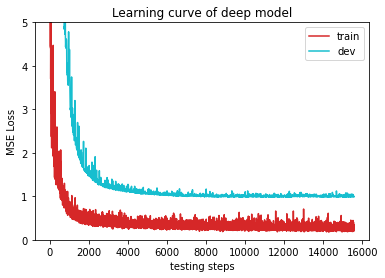

In [40]:
'''训练过程中，训练集和验证集精度变化曲线'''
def plot_learning_curve(loss_record,title=''):
  x_1 = range(len(loss_record['train']))    #训练集数据的横坐标
  x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]   #验证集数据的横坐标
  figure(figsize=[6,4])     #图的大小

  plt.plot(x_1,loss_record['train'],c='tab:red',label='train')    #训练集精度曲线
  plt.plot(x_2,loss_record['dev'],c='tab:cyan',label='dev')     #验证集精度曲线

  #画出图的其它次要部件
  plt.ylim(0.0,5.)    #确定坐标上下限
  plt.xlabel('testing steps')
  plt.ylabel('MSE Loss')
  plt.title('Learning curve of {}'.format(title))
  plt.legend(['train','dev'])   #画出图例
  plt.show()

#画图
plot_learning_curve(model_loss_record,title='deep model')

# 预测结果

In [41]:
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
with open('preds.csv','w') as fp:
  writer = csv.writer(fp)
  writer.writerow(['id','tested_positive'])
  for i in range(preds.shape[0]):
    writer.writerow([i,preds[i]])